In [ ]:
# !pip install pyts
# !pip install tensorflow
# !pip install numpy
# !pip install pandas

In [ ]:
#################
### Libraries ###
#################

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from pyts.image import GramianAngularField, MarkovTransitionField
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import layers
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input, LSTM, Dense, Flatten, Concatenate
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.metrics import RootMeanSquaredError


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
#################
###   Data    ###
#################

bitcoin = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/BTC_noscale.csv')
bitcoin.drop(columns=['Crypto', 'Open', 'High', 'Low'], inplace=True)
bitcoin.head()


,Date,Close
0,2018-01-01,13535.0
1,2018-01-02,14770.0
2,2018-01-03,15057.0
3,2018-01-04,14921.0
4,2018-01-05,16828.0


In [ ]:
########################
## Input GAF/MTF/LSTM ##
########################

btc = bitcoin.iloc[:]

# ------------
# Parameters
# ------------
window_size = 224     # timesteps per sample
image_size = 224      # size for GAF/MTF images
train_ratio = 0.75    # training ratio


# ----------------------
# Step 1 — Normalization
# ----------------------
scaler = MinMaxScaler(feature_range=(0, 1))
btc['close_scaled'] = scaler.fit_transform(btc[['Close']])

# ---------------------------------
# Step 2 — Generate sliding windows
# ---------------------------------
def create_sequences(series, window_size):
    X_seq = []
    y = []
    for i in range(len(series) - window_size):
        X_seq.append(series[i:i+window_size])
        y.append(series[i+window_size])  # predict next value
    return np.array(X_seq), np.array(y)

X_seq, y = create_sequences(btc['close_scaled'].values, window_size)

# ---------------------------------
# Step 3 — GAF & MTF for CNN branch
# ---------------------------------
gasf = GramianAngularField(image_size=image_size, method='summation')
gadf = GramianAngularField(image_size=image_size, method='difference')
mtf = MarkovTransitionField(image_size=image_size)

# Apply transforms to each sequence
X_gasf = gasf.fit_transform(X_seq)
X_gadf = gadf.fit_transform(X_seq)
X_mtf = mtf.fit_transform(X_seq)

# Stack into channels: (samples, H, W, 3)
X_cnn = np.stack((X_gasf, X_gadf, X_mtf), axis=-1)


# --------------------------
# Step 4 — LSTM branch input
# --------------------------
# LSTM expects shape: (samples, timesteps, features)
X_lstm = X_seq.reshape((X_seq.shape[0], X_seq.shape[1], 1))


In [ ]:
# -------------------------------
# Step 5 — Train/Test split
# -------------------------------
n_samples = len(X_seq)
train_end = int(n_samples * train_ratio)

X_cnn_train, X_cnn_test = X_cnn[:train_end], X_cnn[train_end:]
X_lstm_train, X_lstm_test = X_lstm[:train_end], X_lstm[train_end:]
y_train, y_test = y[:train_end], y[train_end:]

# -------------------
# Shapes check
# -------------------
print("CNN train shape:", X_cnn_train.shape)   # (samples, H, W, 3)
print("LSTM train shape:", X_lstm_train.shape) # (samples, timesteps, 1)
print("Targets train shape:", y_train.shape)


CNN train shape: (1314, 224, 224, 3)
LSTM train shape: (1314, 224, 1)
Targets train shape: (1314,)


In [ ]:
################
### CNN-LSTM ###
################

# ------------------------
# Step 1 — Build Input CNN
# ------------------------
cnn_input = Input(shape=(224, 224, 3))

# --------------------------------------------
# Step 2 — Build VGG16 Model (pre-trained CNN)
# --------------------------------------------

vgg = VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)


# ----------------------------------
# Step 3 — Convolution/Pooling/Dense
# ----------------------------------

# Conv2D 64-10, Flatten, Dense(200)
x = vgg(cnn_input)
x = layers.Conv2D(64, (2, 2), activation='relu')(x)
x = layers.Conv2D(10, (2, 2), activation='relu')(x)
x = layers.Flatten()(x)
x = layers.Dense(200, activation='relu')(x)
cnn_out = x

# ---------------------------
# Step 4 — Input LSTM
# ---------------------------

# Parameters
act_func = 'tanh'
n_timesteps = X_lstm_train.shape[1]
n_features = X_lstm_train.shape[2]

# ---------------------------
# Step 5 — LSTM structure
# ---------------------------

lstm_input = Input(shape=(n_timesteps,n_features))
y = LSTM(64, return_sequences=True, activation='tanh')(lstm_input)
y = LSTM(16, return_sequences=True, activation='tanh')(y)
y = LSTM(2, return_sequences=False, activation='tanh')(y)
lstm_out = y

# ---------------------------
# Step 6 — Concated O/P
# ---------------------------

combined = Concatenate()([cnn_out, lstm_out])
output = Dense(1, activation='linear')(combined)

# ----------------------------------
# Step 7 — Compile Model/Regression
# ----------------------------------

model = Model(inputs=[cnn_input, lstm_input], outputs=output)
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae', RootMeanSquaredError(), 'mape'])


In [ ]:
# --------------------
# Step 8 — Training
# --------------------

history = model.fit([X_cnn_train, X_lstm_train], y_train,
                   epochs=100, batch_size=64,
                   verbose=2)


Epoch 1/100
21/21 - 32s - 2s/step - loss: 3.2295 - mae: 0.7072 - mape: 207848.5312 - root_mean_squared_error: 1.7971
Epoch 2/100
21/21 - 16s - 763ms/step - loss: 0.1236 - mae: 0.2520 - mape: 108809.2266 - root_mean_squared_error: 0.3516
Epoch 3/100
21/21 - 21s - 981ms/step - loss: 0.0806 - mae: 0.2236 - mape: 207520.0781 - root_mean_squared_error: 0.2839
Epoch 4/100
21/21 - 16s - 776ms/step - loss: 0.0520 - mae: 0.1687 - mape: 132399.5312 - root_mean_squared_error: 0.2280
Epoch 5/100
21/21 - 16s - 781ms/step - loss: 0.0357 - mae: 0.1495 - mape: 102449.5703 - root_mean_squared_error: 0.1888
Epoch 6/100
21/21 - 21s - 978ms/step - loss: 0.0437 - mae: 0.1532 - mape: 91579.6406 - root_mean_squared_error: 0.2091
Epoch 7/100
21/21 - 20s - 975ms/step - loss: 0.0279 - mae: 0.1173 - mape: 122312.5625 - root_mean_squared_error: 0.1669
Epoch 8/100
21/21 - 20s - 971ms/step - loss: 0.0202 - mae: 0.0984 - mape: 77927.2734 - root_mean_squared_error: 0.1420
Epoch 9/100
21/21 - 20s - 974ms/step - loss: 

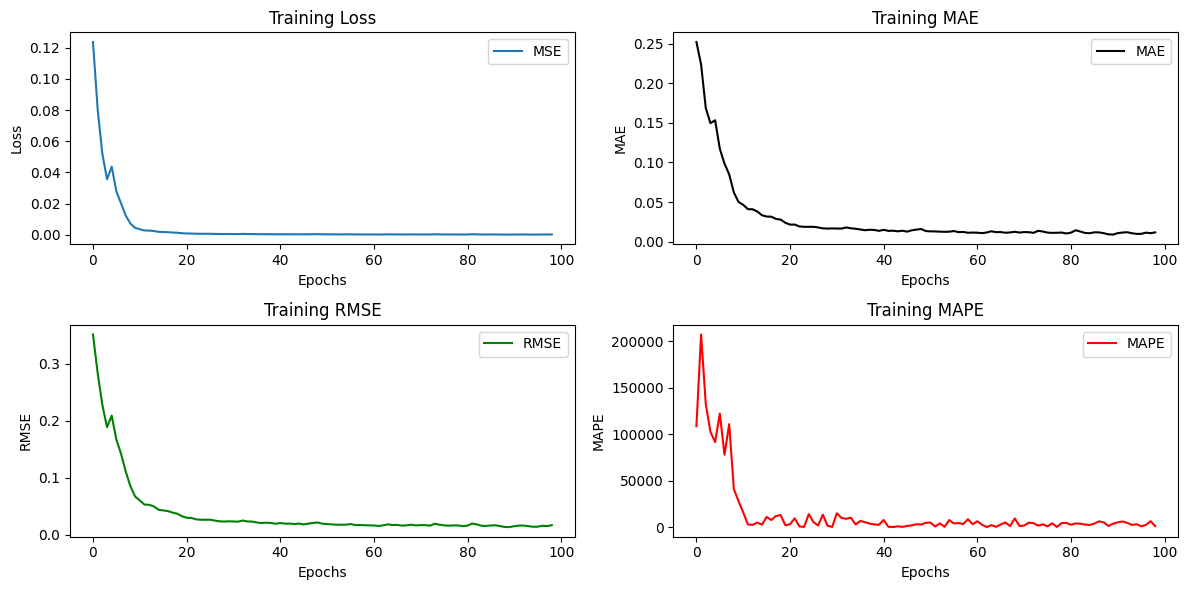

In [ ]:
####################
### Plot Results ###
####################

# Training MSE
fig, ax = plt.subplots(2, 2, figsize=(12, 6))
ax[0, 0].plot(history.history['loss'][1:], label='MSE')
ax[0, 0].set_title('Training Loss')
ax[0, 0].set_xlabel('Epochs')
ax[0, 0].set_ylabel('Loss')
ax[0, 0].legend()

# Training MAE
ax[0, 1].plot(history.history['mae'][1:], label='MAE', color='black')
ax[0, 1].set_title('Training MAE')
ax[0, 1].set_xlabel('Epochs')
ax[0, 1].set_ylabel('MAE')
ax[0, 1].legend()

# Training RMSE
ax[1, 0].plot(history.history['root_mean_squared_error'][1:], label='RMSE', color='green')
ax[1, 0].set_title('Training RMSE')
ax[1, 0].set_xlabel('Epochs')
ax[1, 0].set_ylabel('RMSE')
ax[1, 0].legend()

# Training MAPE
ax[1, 1].plot(history.history['mape'][1:], label='MAPE', color='red')
ax[1, 1].set_title('Training MAPE')
ax[1, 1].set_xlabel('Epochs')
ax[1, 1].set_ylabel('MAPE')
ax[1, 1].legend()

plt.tight_layout()
plt.show()

In [ ]:
#####################
## Predict/Testing ##
#####################

y_predict= model.predict([X_cnn_test, X_lstm_test])


14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 183ms/step


In [ ]:
y_predict

array([[0.59283245],
       [0.6021078 ],
       [0.60949576],
       [0.61243963],
       [0.62360835],
       [0.63073635],
       [0.64593947],
       [0.6565118 ],
       [0.663054  ],
       [0.67562693],
       [0.6849498 ],
       [0.6889471 ],
       [0.6892807 ],
       [0.67037123],
       [0.66597265],
       [0.671935  ],
       [0.67299294],
       [0.67497784],
       [0.66833925],
       [0.66729194],
       [0.6621142 ],
       [0.6616007 ],
       [0.657754  ],
       [0.6602118 ],
       [0.65230215],
       [0.6530675 ],
       [0.6512754 ],
       [0.65662426],
       [0.6543371 ],
       [0.65622824],
       [0.6571247 ],
       [0.6616371 ],
       [0.66291   ],
       [0.66609967],
       [0.66729224],
       [0.6657173 ],
       [0.6631273 ],
       [0.66349363],
       [0.66365796],
       [0.6621275 ],
       [0.6640329 ],
       [0.66423815],
       [0.66518855],
       [0.6571871 ],
       [0.6573006 ],
       [0.6534183 ],
       [0.6550167 ],
       [0.650

In [ ]:
# Test MSE
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test, y_predict)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.09138306138693564


In [ ]:
y_test.shape

(439,)

In [ ]:
#--------------------------------------
# Inverse scaling: original price scale
#--------------------------------------

y_test_orig = scaler.inverse_transform(y_test.reshape(-1, 1))
y_predict_orig = scaler.inverse_transform(y_predict)

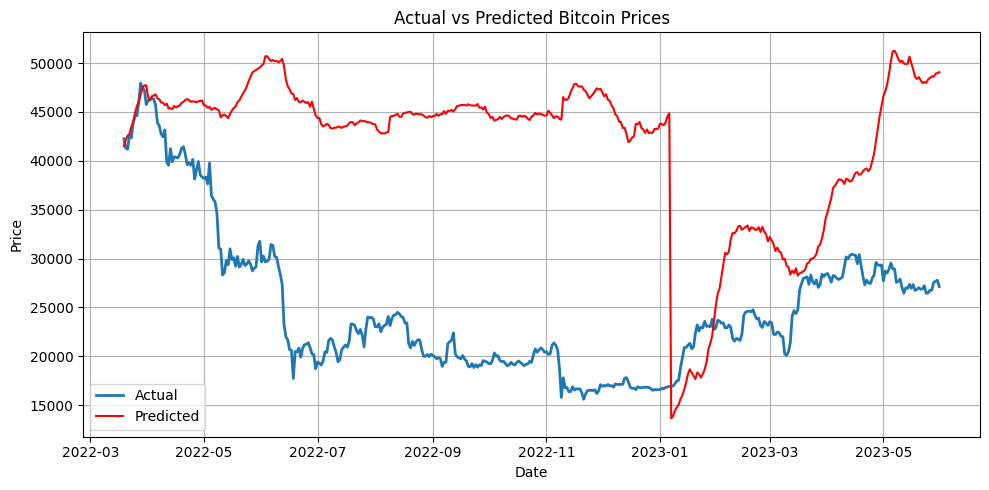

In [ ]:
#-----------------------------
# Plot prediction vs. actuals
#-----------------------------

start_index = len(y_train)+ 224

dates = btc['Date'].iloc[start_index:start_index + len(y_test_orig)].reset_index(drop=True)

# Convert to datetime if not already
dates = pd.to_datetime(dates)

# Plot the actual vs predicted prices
plt.figure(figsize=(10, 5))
plt.plot(dates, y_test_orig, label='Actual', linewidth=2)
plt.plot(dates, y_predict_orig, label='Predicted', color='red')
plt.title('Actual vs Predicted Bitcoin Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Export results

loss_results = pd.DataFrame(history.history)
loss_results.to_csv('loss_results.csv')

from google.colab import files
files.download('loss_results.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>